In [31]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils.utils import load_dataset, download_dataset, create_cnn_model, get_callbacks, get_preds, show_train_loss_accuracy, show_metrics, INPUT_SHAPE, OUTPUT_CLASSES
%matplotlib inline
warnings.filterwarnings('ignore')

In [32]:
DATA_PATH = "./data"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [33]:
download_dataset(DATA_PATH)

✅ Dataset já existe em: ./data
Pulando download...


In [34]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 48, 48, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

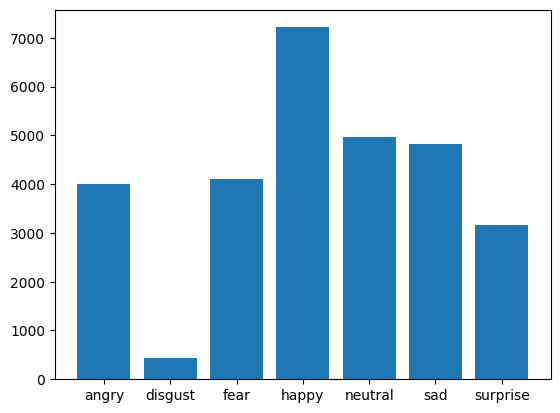

In [35]:
plt.bar(LABEL_MAP.keys(), np.bincount(y_train))
plt.show()

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
augmented_labels = []

happy_count = np.bincount(y_train)[LABEL_MAP['happy']]
target_count = happy_count

for class_name, class_idx in LABEL_MAP.items():
    class_mask = y_train == class_idx
    class_images = X_train[class_mask]
    class_labels = y_train[class_mask]
    current_count = class_images.shape[0]
    if current_count < target_count:
        needed = target_count - current_count
        gen = datagen.flow(class_images, class_labels, batch_size=1, shuffle=True)
        for _ in range(needed):
            img, lbl = next(gen)
            augmented_images.append(img[0].astype('uint8'))
            augmented_labels.append(lbl[0])

if augmented_images:
    X_train_augmented = np.array(augmented_images)
    y_train_augmented = np.array(augmented_labels)
    X_train = np.concatenate((X_train, X_train_augmented), axis=0)
    y_train = np.concatenate((y_train, y_train_augmented), axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train.shape, y_train.shape

((50505, 48, 48, 3), (50505,))

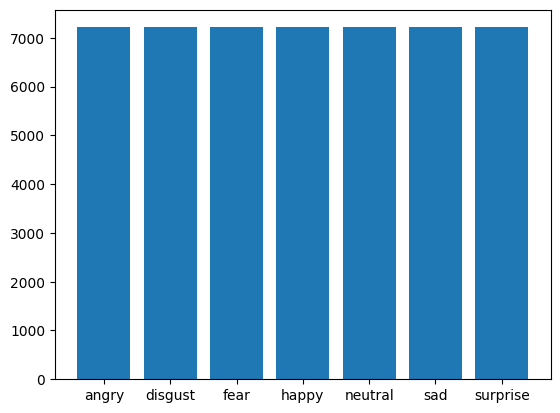

In [37]:
plt.bar(LABEL_MAP.keys(), np.bincount(y_train))
plt.show()

In [38]:
AUGMENTED_DATASET_PATH = "./augmented_dataset/train"
if not os.path.exists(AUGMENTED_DATASET_PATH):
    os.makedirs(AUGMENTED_DATASET_PATH)
for idx, (img, label) in enumerate(zip(X_train, y_train)):
    class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(label)]
    class_dir = os.path.join(AUGMENTED_DATASET_PATH, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    img_path = os.path.join(class_dir, f"{idx}.png")
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
X_train.shape, y_train.shape

((50505, 48, 48, 3), (50505,))